In [24]:
from astropy.io import fits as pyfits
import numpy as np
import matplotlib.pyplot as pl
import glob
import os
%matplotlib inline

In [79]:
def getFlux(plot=True):
    """Return a (random) stitching of the postage stamps for C9."""
    ntime = 1290
    nrows = 100
    ncols = 100
    ntries = 100
    flux = np.zeros((ntime, nrows, ncols))
    files = glob.glob('data/c9/*/*/*.fits.gz')

    for file in files:
        with pyfits.open(file) as f:
            ftmp = f[1].data['FLUX']
            for i in range(ntries):
                row = np.random.randint(0, nrows - ftmp.shape[1])
                col = np.random.randint(0, ncols - ftmp.shape[2])
                if np.all(flux[0, row:row + ftmp.shape[1], col:col + ftmp.shape[2]] == 0):
                    flux[:, row:row + ftmp.shape[1], col:col + ftmp.shape[2]] = ftmp
                    break
            if i == ntries - 1:
                raise Exception("Unable to place image.")
    if plot:
        fig = pl.figure(figsize=(14, 14))
        pl.imshow(flux[0], vmax=1e4);
    return flux

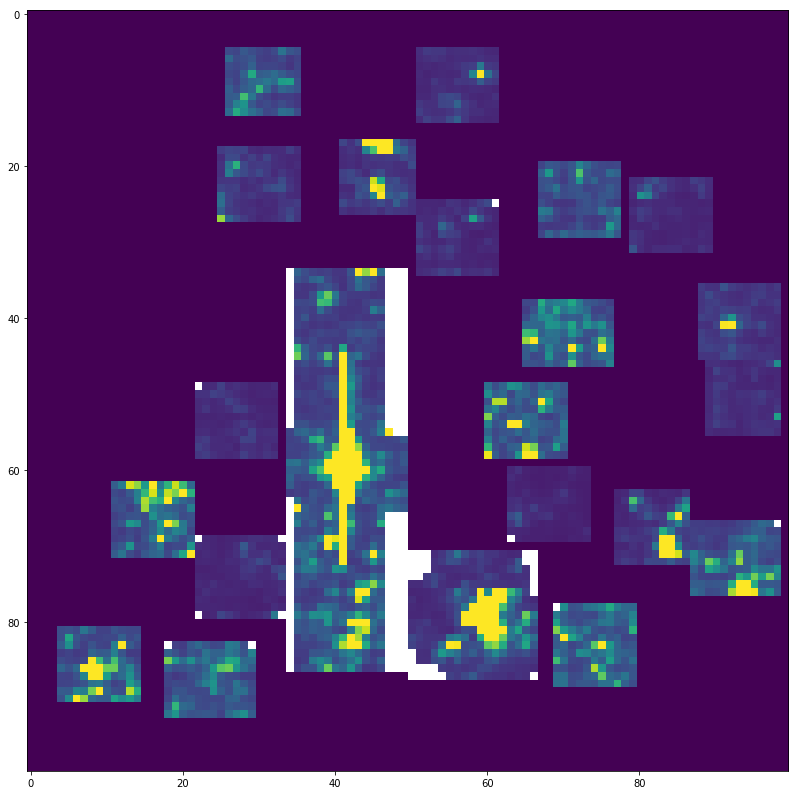

In [81]:
flux = getFlux()